In [ ]:
%pip install diffusers["torch"] transformers
%pip install torchmetrics

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import matplotlib.pyplot as plt


import torchvision.datasets as dset
from torchvision.datasets import MNIST, CIFAR10
import torchvision.transforms as T
import torchvision.transforms as transforms
import torchvision.transforms.functional
from torchvision.transforms import v2
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim import AdamW
from tqdm import tqdm
import math
import torch.nn.functional as F

import numpy as np
from torchmetrics.image.inception import InceptionScore


In [14]:
# select device
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
elif torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
else:
    DEVICE = torch.device('cpu')

print(f'{DEVICE=}')

# hyper param

DATASET = 'CIFAR10' # CIFAR10 or MNIST
print(f'{DATASET=}')
if DATASET == 'MNIST':
    IMG_SIZE = (28, 28, 1)
    DATASET = MNIST
elif DATASET == 'CIFAR10':
    IMG_SIZE = (32, 32, 3)
    DATASET = CIFAR10
print(f'{IMG_SIZE=}')

BATCH_SIZE = 64
N_LAYERS = 8
HIDDEN_DIM = 256
HIDDEN_DIMS = [HIDDEN_DIM for _ in range(N_LAYERS)]
N_TIMESTAMPS = 1000
TIMESTAMP_EMBED_DIM = 256
BETA_MIN_MAX = [1e-4, 2e-2]
LEARNING_RATE = 5e-5
N_EPOCH = 5

# prepare data

dataset_path = './datasets'
# transform = transforms.Compose([transforms.ToTensor()]) # TODO: try subtract mean & div by std
transform = v2.Compose([v2.ToImage(), v2.ToDtype(torch.uint8, scale=False)])
train_dataset = DATASET(dataset_path, transform=transform,
                      train=True, download=True)
eval_dataset = DATASET(dataset_path, transform=transform,
                    train=True, download=True)
test_dataset = DATASET(dataset_path, transform=transform,
                     train=False, download=True)
NUM_DATASET = len(train_dataset)
NUM_DATASET = 10000 # use a smaller dataset
NUM_TRAIN = int(NUM_DATASET * 0.8)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
train_sample = list(train_loader)[0][0]

# print(train_dataset.data.type())
# print(train_dataset.data.float().mean(), train_dataset.data.min(), train_dataset.data.max(), train_dataset.data.shape)
# print(train_sample.mean(), train_sample.min(), train_sample.max(), train_sample.shape)

eval_loader = DataLoader(dataset=eval_dataset, batch_size=BATCH_SIZE,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, NUM_DATASET)))
test_loader = DataLoader(dataset=test_dataset,  batch_size=BATCH_SIZE)

print(f'{NUM_TRAIN=}')

DEVICE=device(type='mps')
DATASET='CIFAR10'
IMG_SIZE=(32, 32, 3)
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
NUM_TRAIN=8000


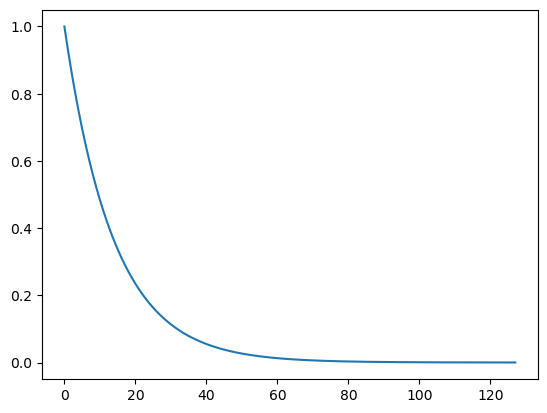

In [3]:
dim = 256
half_dim = dim // 2
emb = math.log(10000) / (half_dim - 1)
emb = torch.exp(torch.arange(half_dim) * -emb)
plt.plot(emb)
plt.show()
        # emb = x[:, None] * emb[None, :]
        # emb = torch.cat((emb.sin(), emb.cos()), dim=-1)

In [4]:
# not in use yet
class UNet(nn.Module):
    def __int__(self, in_channels):
        super().__init__()
        self.in_channels = in_channels
        self.down_conv_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=64,
                      kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64,
                      kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.down_conv_2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128,
                      kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128,
                      kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.down_conv_3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256,
                      kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256,
                      kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.down_conv_4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512,
                      kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512,
                      kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.middle_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024,
                      kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=1024,
                      kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.up_sample_4 = nn.ConvTranspose2d(
            in_channels=1024, out_channels=512, kernel_size=2, stride=2)
        self.up_sample_3 = nn.ConvTranspose2d(
            in_channels=512, out_channels=256, kernel_size=2, stride=2)
        self.up_sample_2 = nn.ConvTranspose2d(
            in_channels=256, out_channels=128, kernel_size=2, stride=2)
        self.up_sample_1 = nn.ConvTranspose2d(
            in_channels=128, out_channels=64, kernel_size=2, stride=2)
        self.up_conv_1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64,
                      kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64,
                      kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.up_conv_2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128,
                      kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128,
                      kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.up_conv_3 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256,
                      kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256,
                      kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.up_conv_4 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512,
                      kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512,
                      kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.final_conv = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)

    def forward(self, x):
        c, h, w = x.shape
        assert c == self.in_channels

        # level 1
        x = self.down_conv_1(x)
        pass_through_1 = x
        x = F.max_pool2d(x, kernel_size=2)

        # level 2
        x = self.down_conv_2(x)
        pass_through_2 = x
        x = F.max_pool2d(x, kernel_size=2)

        # level 3
        x = self.down_conv_3(x)
        pass_through_3 = x
        x = F.max_pool2d(x, kernel_size=2)

        # level 4
        x = self.down_conv_4(x)
        pass_through_4 = x
        x = F.max_pool2d(x, kernel_size=2)
        assert x.shape[2] == 512

        # level 5
        x = self.middle_conv(x)

        # level 4
        x = self.up_sample_4(x)
        pass_through_4 = torchvision.transforms.functional.center_crop(
            pass_through_4, [x.shape[2], x.shape[3]])  # why? shape[2] and shape[3]?
        x = torch.cat([x, pass_through_4], dim=1)
        x = self.up_conv_4(x)

        # level 3
        x = self.up_sample_3(x)
        pass_through_3 = torchvision.transforms.functional.center_crop(
            pass_through_3, [x.shape[2], x.shape[3]])
        x = torch.cat([x, pass_through_3], dim=1)
        x = self.up_conv_3(x)

        # level 2
        x = self.up_sample_2(x)
        pass_through_2 = torchvision.transforms.functional.center_crop(
            pass_through_2, [x.shape[2], x.shape[3]])
        x = torch.cat([x, pass_through_2], dim=1)
        x = self.up_conv_2(x)

        # level 1
        x = self.up_sample_1(x)
        pass_through_1 = torchvision.transforms.functional.center_crop(
            pass_through_1, [x.shape[2], x.shape[3]])
        x = torch.cat([x, pass_through_1], dim=1)
        x = self.up_conv_1(x)

        x = self.final_conv(x)
        return x

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


class ConvBlock(nn.Conv2d):
    """
        Conv2D Block
            Args:
                x: (N, C_in, H, W)
            Returns:
                y: (N, C_out, H, W)
    """

    def __init__(self, in_channels, out_channels, kernel_size, activation_fn=None, drop_rate=0.,
                 stride=1, padding='same', dilation=1, groups=1, bias=True, gn=False, gn_groups=8):

        if padding == 'same':
            padding = kernel_size // 2 * dilation

        super(ConvBlock, self).__init__(in_channels, out_channels, kernel_size,
                                        stride=stride, padding=padding, dilation=dilation,
                                        groups=groups, bias=bias)

        self.activation_fn = nn.SiLU() if activation_fn else None
        self.group_norm = nn.GroupNorm(gn_groups, out_channels) if gn else None

    def forward(self, x, time_embedding=None, residual=False):

        if residual:
            # in the paper, diffusion timestep embedding was only applied to residual blocks of U-Net
            x = x + time_embedding
            y = x
            x = super(ConvBlock, self).forward(x)
            y = y + x
        else:
            y = super(ConvBlock, self).forward(x)
        y = self.group_norm(y) if self.group_norm is not None else y
        y = self.activation_fn(y) if self.activation_fn is not None else y

        return y


class Denoiser(nn.Module):

    def __init__(self, image_resolution, hidden_dims=[256, 256], diffusion_time_embedding_dim=256, n_times=1000):
        """
        image_resolution: example array [32, 32, 3]

        """
        super(Denoiser, self).__init__()

        _, _, img_C = image_resolution

        self.time_embedding = SinusoidalPosEmb(diffusion_time_embedding_dim)

        self.in_project = ConvBlock(img_C, hidden_dims[0], kernel_size=7)

        self.time_project = nn.Sequential(
            ConvBlock(diffusion_time_embedding_dim,
                      hidden_dims[0], kernel_size=1, activation_fn=True),
            ConvBlock(hidden_dims[0], hidden_dims[0], kernel_size=1))

        self.convs = nn.ModuleList([ConvBlock(
            in_channels=hidden_dims[0], out_channels=hidden_dims[0], kernel_size=3)])

        for idx in range(1, len(hidden_dims)):
            self.convs.append(ConvBlock(hidden_dims[idx-1], hidden_dims[idx], kernel_size=3, dilation=3**((idx-1)//2),
                                        activation_fn=True, gn=True, gn_groups=8))

        self.out_project = ConvBlock(
            hidden_dims[-1], out_channels=img_C, kernel_size=3)

    def forward(self, perturbed_x, diffusion_t):
        y = perturbed_x

        diffusion_embedding = self.time_embedding(diffusion_t)
        diffusion_embedding = self.time_project(
            diffusion_embedding.unsqueeze(-1).unsqueeze(-2))

        y = self.in_project(y)

        for i in range(len(self.convs)):
            y = self.convs[i](y, diffusion_embedding, residual=True)

        y = self.out_project(y)

        return y


model = Denoiser(image_resolution=IMG_SIZE,
                 hidden_dims=HIDDEN_DIMS,
                 diffusion_time_embedding_dim=TIMESTAMP_EMBED_DIM,
                 n_times=N_TIMESTAMPS).to(DEVICE)

In [5]:
class Diffusion(nn.Module):
    def __init__(self, model, image_resolution=[32, 32, 3], n_times=1000, beta_minmax=[1e-4, 2e-2], device='cuda'):

        super(Diffusion, self).__init__()

        self.n_times = n_times
        self.img_H, self.img_W, self.img_C = image_resolution

        self.model = model

        # define linear variance schedule(betas)
        beta_1, beta_T = beta_minmax
        betas = torch.linspace(start=beta_1, end=beta_T, steps=n_times).to(
            device)  # follows DDPM paper
        self.sqrt_betas = torch.sqrt(betas)

        # define alpha for forward diffusion kernel
        self.alphas = 1 - betas
        self.sqrt_alphas = torch.sqrt(self.alphas)
        alpha_bars = torch.cumprod(self.alphas, dim=0)
        self.sqrt_one_minus_alpha_bars = torch.sqrt(1-alpha_bars)
        self.sqrt_alpha_bars = torch.sqrt(alpha_bars)

        self.device = device

    def extract(self, a, t, x_shape):
        b, *_ = t.shape
        out = a.gather(-1, t)
        return out.reshape(b, *((1,) * (len(x_shape) - 1)))

    def scale_to_minus_one_to_one(self, x):
        # according to the DDPMs paper, normalization seems to be crucial to train reverse process network
        return x * 2 - 1

    def reverse_scale_to_zero_to_one(self, x):
        return (x + 1) * 0.5

    def make_noisy(self, x_zeros, t):
        # perturb x_0 into x_t (i.e., take x_0 samples into forward diffusion kernels)
        epsilon = torch.randn_like(x_zeros).to(self.device)

        sqrt_alpha_bar = self.extract(self.sqrt_alpha_bars, t, x_zeros.shape)
        sqrt_one_minus_alpha_bar = self.extract(
            self.sqrt_one_minus_alpha_bars, t, x_zeros.shape)

        # Let's make noisy sample!: i.e., Forward process with fixed variance schedule
        #      i.e., sqrt(alpha_bar_t) * x_zero + sqrt(1-alpha_bar_t) * epsilon
        noisy_sample = x_zeros * sqrt_alpha_bar + epsilon * sqrt_one_minus_alpha_bar

        return noisy_sample.detach(), epsilon

    def forward(self, x_zeros):
        x_zeros = self.scale_to_minus_one_to_one(x_zeros)

        B, _, _, _ = x_zeros.shape

        # (1) randomly choose diffusion time-step
        t = torch.randint(low=0, high=self.n_times,
                          size=(B,)).long().to(self.device)

        # (2) forward diffusion process: perturb x_zeros with fixed variance schedule
        perturbed_images, epsilon = self.make_noisy(x_zeros, t)

        # (3) predict epsilon(noise) given perturbed data at diffusion-timestep t.
        pred_epsilon = self.model(perturbed_images, t)

        return perturbed_images, epsilon, pred_epsilon

    def denoise_at_t(self, x_t, timestep, t):
        B, _, _, _ = x_t.shape
        if t > 1:
            z = torch.randn_like(x_t).to(self.device)
        else:
            z = torch.zeros_like(x_t).to(self.device)

        # at inference, we use predicted noise(epsilon) to restore perturbed data sample.
        epsilon_pred = self.model(x_t, timestep)

        alpha = self.extract(self.alphas, timestep, x_t.shape)
        sqrt_alpha = self.extract(self.sqrt_alphas, timestep, x_t.shape)
        sqrt_one_minus_alpha_bar = self.extract(
            self.sqrt_one_minus_alpha_bars, timestep, x_t.shape)
        sqrt_beta = self.extract(self.sqrt_betas, timestep, x_t.shape)

        # denoise at time t, utilizing predicted noise
        x_t_minus_1 = 1 / sqrt_alpha * \
            (x_t - (1-alpha)/sqrt_one_minus_alpha_bar*epsilon_pred) + sqrt_beta*z

        return x_t_minus_1.clamp(-1., 1)

    def sample(self, N):
        # start from random noise vector, x_0 (for simplicity, x_T declared as x_t instead of x_T)
        x_t = torch.randn((N, self.img_C, self.img_H,
                          self.img_W)).to(self.device)

        # autoregressively denoise from x_T to x_0
        #     i.e., generate image from noise, x_T
        for t in range(self.n_times-1, -1, -1):
            timestep = torch.tensor([t]).repeat_interleave(
                N, dim=0).long().to(self.device)
            x_t = self.denoise_at_t(x_t, timestep, t)

        # denormalize x_0 into 0 ~ 1 ranged values.
        x_0 = self.reverse_scale_to_zero_to_one(x_t)

        return x_0


diffusion = Diffusion(model, image_resolution=IMG_SIZE, n_times=N_TIMESTAMPS,
                      beta_minmax=BETA_MIN_MAX, device=DEVICE).to(DEVICE)

optimizer = Adam(diffusion.parameters(), lr=LEARNING_RATE)
denoising_loss = nn.MSELoss()

Number of model parameters:  4870913
tensor(0.1322) tensor(0.) tensor(1.) torch.Size([64, 1, 28, 28])


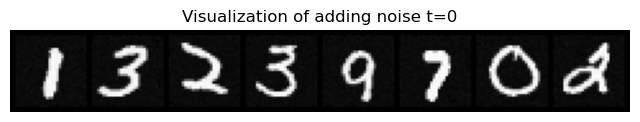

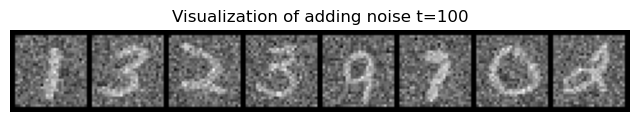

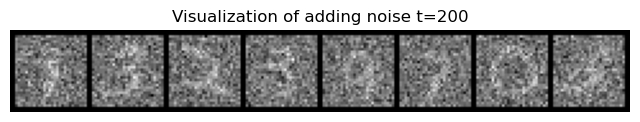

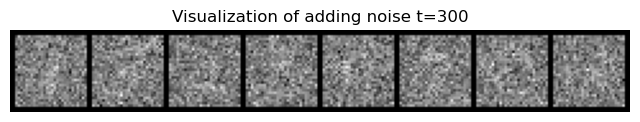

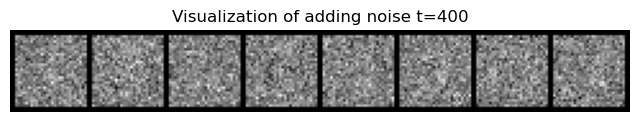

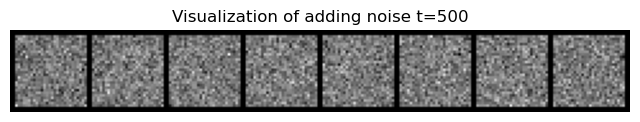

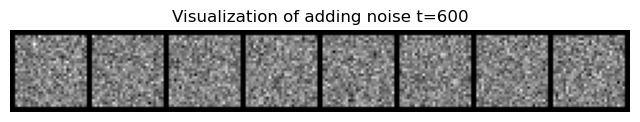

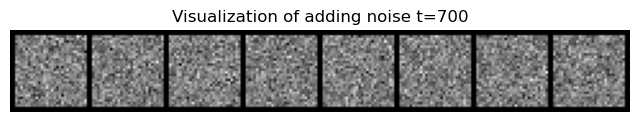

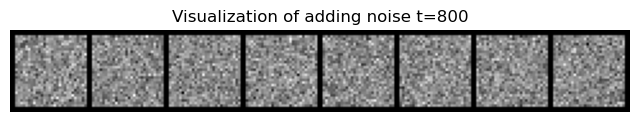

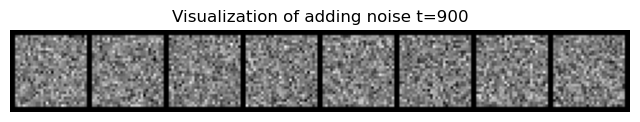

In [6]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print("Number of model parameters: ", count_parameters(diffusion))

# from torchsummary import summary

# summary(diffusion, (1, 28, 28))

def show_image(image):
    # assert image.shape == (1, 28, 28)
    fig = plt.figure()
    plt.imshow(image.transpose(0, 1).transpose(1, 2).detach().cpu().numpy())


def draw_sample_image(x, postfix):
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("Visualization of {}".format(postfix))
    plt.imshow(np.transpose(make_grid(x.detach().cpu(),
               padding=2, normalize=True), (1, 2, 0)))


model.eval()
for batch_idx, (x, class_) in enumerate(train_loader):
    print(x.mean(), x.min(), x.max(), x.shape)
    x = x[:8].to(DEVICE)
    # perturbed_images, epsilon, pred_epsilon = diffusion(x)
    # perturbed_images = diffusion.reverse_scale_to_zero_to_one(perturbed_images)
    for t in range(0, N_TIMESTAMPS, 100):
        noisy_sample, _ = diffusion.make_noisy(
            x, torch.full((8, ), t).to(DEVICE))
        # print(f'{len(noisy_sample)}')
        # show_image(noisy_sample[0])
        draw_sample_image(noisy_sample, f"adding noise t={t}")
    break

# print(f'{len(perturbed_images)=}')
# show_image(perturbed_images[0])
# show_image(perturbed_images[1])
# show_image(perturbed_images[63])

In [ ]:
print("Start training DDPMs...")
model.train()

train_loss_arr = [0]
eval_loss_arr = [0]
iters = [0]
EVAL_EVERY = 10

@torch.no_grad()
def eval(num_batch=10):
    model.eval()
    with torch.no_grad():
        eval_loss = 0.0
        train_loss = 0.0
        for train_batch_idx, (x, _) in enumerate(train_loader):
            x = x.to(DEVICE)
            _, epsilon, pred_epsilon = diffusion(x)
            train_loss += denoising_loss(pred_epsilon, epsilon)
            if train_batch_idx > num_batch:
                break
        for eval_batch_idx, (x, _) in enumerate(eval_loader):
            x = x.to(DEVICE)
            _, epsilon, pred_epsilon = diffusion(x)
            eval_loss += denoising_loss(pred_epsilon, epsilon)
            if eval_batch_idx > num_batch:
                break

    eval_loss /= eval_batch_idx
    train_loss /= train_batch_idx
    train_loss_arr.append(train_loss.detach())
    eval_loss_arr.append(eval_loss.detach())
    iters.append(iters[-1] + EVAL_EVERY)
    print(f"train loss {train_loss} eval loss {eval_loss}")
    model.train()

i = 0
for epoch in range(N_EPOCH):
    noise_prediction_loss = 0
    for batch_idx, (x, _) in tqdm(enumerate(train_loader), total=len(train_loader)):
        i += 1
        if i % EVAL_EVERY == 0:
            i = 0
            eval()

        optimizer.zero_grad()

        x = x.to(DEVICE)

        noisy_input, epsilon, pred_epsilon = diffusion(x)
        loss = denoising_loss(pred_epsilon, epsilon)

        noise_prediction_loss += loss.item()

        loss.backward()
        optimizer.step()


    print("\tEpoch", epoch + 1, "complete!",
          "\tDenoising Loss: ", noise_prediction_loss / batch_idx)

print("Finish!!")

In [ ]:
plt.figure()
plt.plot(iters[1:], torch.stack(train_loss_arr[1:]).cpu().detach().numpy(), label = 'train')
plt.plot(iters[1:], torch.stack(eval_loss_arr[1:]).cpu().detach().numpy(), label = 'validation')
plt.xlabel('iters')
plt.ylabel('loss')
plt.legend()
plt.title('training loss vs validation loss')

In [ ]:
model.eval()

with torch.no_grad():
    generated_images = diffusion.sample(N=8)


In [ ]:
show_image(generated_images[0])

In [ ]:

# draw_sample_image(perturbed_images, "Perturbed Images")
draw_sample_image(generated_images, "Generated Images")
draw_sample_image(x[:8], "Ground-truth Images")


In [13]:
from ignite.metrics import InceptionScore
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained('1aurent/ddpm-mnist').to(DEVICE)
print(f'{pipeline.device}')

images = torch.tensor([])
for i in range(10):
    image_tensor = torchvision.transforms.functional.pil_to_tensor(pipeline().images[0])
    images = torch.cat((images, image_tensor))
    print(images.shape)

# metric = InceptionScore()
# metric.attach(default_evaluator, "is")
# y = torch.rand(10, 3, 299, 299)
# state = default_evaluator.run([y])
# print(state.metrics["is"])


Loading pipeline components...: 100%|██████████| 2/2 [00:00<00:00, 58.45it/s]


mps:0


100%|██████████| 1000/1000 [00:34<00:00, 29.15it/s]


torch.Size([1, 28, 28])


100%|██████████| 1000/1000 [00:34<00:00, 29.08it/s]


torch.Size([2, 28, 28])


 46%|████▌     | 458/1000 [00:15<00:18, 29.09it/s]


KeyboardInterrupt: 

In [ ]:
inception = InceptionScore()
# generate some images
# imgs = torch.randint(0, 255, (100, 3, 299, 299), dtype=torch.uint8)
# print(type(image))
for image in images:
    
    image_tensor = torchvision.transforms.functional.pil_to_tensor(image)
    print(f'{image_tensor.float().mean()=} {image_tensor.min()=} {image_tensor.max()=} {image_tensor.shape=}')
    # print(image_tensor)
    # print(image_tensor.expand(1, 3, 28, 28))
    expanded_image_tensor = image_tensor.expand(1, 3, 28, 28)
    # print(f'{expanded_image_tensor.shape}')
    inception.update(expanded_image_tensor)
    print(f'{inception.compute()=}')

In [27]:
# inception = InceptionScore()
# imgs = torch.randint(0, 255, (64, 3, 32, 32), dtype=torch.uint8)
# inception.update(imgs)
# print(inception.compute())


pure_noise_is = InceptionScore()
cifar10_is = InceptionScore()
# train_batch_sample = list(train_loader)[0][0]
for batch_idx, (x, class_) in tqdm(enumerate(train_loader), total=len(train_loader)):
    cifar10_is.update(x)
    noise = torch.randint(0, 255, (64, 3, 32, 32), dtype=torch.uint8)
    pure_noise_is.update(noise)
    print(f'{pure_noise_is.compute()=} {cifar10_is.compute()=}')
# print(train_batch_sample)
# print(train_batch_sample.shape)

inception.compute()

/Users/lihenan/miniconda3/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028
  1%|          | 1/125 [00:16<33:50, 16.37s/it]

pure_noise_is.compute()=(tensor(1.1649), tensor(0.0789)) cifar10_is.compute()=(tensor(3.5353), tensor(1.0350))


  2%|▏         | 2/125 [00:31<32:04, 15.65s/it]

pure_noise_is.compute()=(tensor(1.1876), tensor(0.0452)) cifar10_is.compute()=(tensor(4.9440), tensor(0.5518))


  2%|▏         | 3/125 [00:46<31:22, 15.43s/it]

pure_noise_is.compute()=(tensor(1.1981), tensor(0.0291)) cifar10_is.compute()=(tensor(5.9622), tensor(1.0769))


  3%|▎         | 4/125 [01:01<30:59, 15.37s/it]

pure_noise_is.compute()=(tensor(1.2080), tensor(0.0423)) cifar10_is.compute()=(tensor(6.9489), tensor(0.9385))


  4%|▍         | 5/125 [01:17<31:01, 15.52s/it]

pure_noise_is.compute()=(tensor(1.2129), tensor(0.0246)) cifar10_is.compute()=(tensor(7.3108), tensor(0.7411))


  5%|▍         | 6/125 [01:32<30:25, 15.34s/it]

pure_noise_is.compute()=(tensor(1.2162), tensor(0.0220)) cifar10_is.compute()=(tensor(7.8571), tensor(1.1115))


  6%|▌         | 7/125 [01:47<29:50, 15.18s/it]

pure_noise_is.compute()=(tensor(1.2213), tensor(0.0222)) cifar10_is.compute()=(tensor(8.1360), tensor(1.0169))


  6%|▋         | 8/125 [02:02<29:08, 14.94s/it]

pure_noise_is.compute()=(tensor(1.2195), tensor(0.0337)) cifar10_is.compute()=(tensor(8.5962), tensor(1.0706))


  7%|▋         | 9/125 [02:17<28:56, 14.97s/it]

pure_noise_is.compute()=(tensor(1.2188), tensor(0.0296)) cifar10_is.compute()=(tensor(8.5799), tensor(0.8189))


  8%|▊         | 10/125 [02:31<28:31, 14.89s/it]

pure_noise_is.compute()=(tensor(1.2202), tensor(0.0122)) cifar10_is.compute()=(tensor(8.7639), tensor(0.4567))


  9%|▉         | 11/125 [02:46<28:20, 14.92s/it]

pure_noise_is.compute()=(tensor(1.2188), tensor(0.0169)) cifar10_is.compute()=(tensor(8.9538), tensor(0.7187))


 10%|▉         | 12/125 [03:01<28:09, 14.95s/it]

pure_noise_is.compute()=(tensor(1.2198), tensor(0.0155)) cifar10_is.compute()=(tensor(9.0569), tensor(0.4573))


 10%|█         | 13/125 [03:16<27:44, 14.86s/it]

pure_noise_is.compute()=(tensor(1.2193), tensor(0.0172)) cifar10_is.compute()=(tensor(9.1784), tensor(1.2059))


 11%|█         | 14/125 [03:30<27:19, 14.77s/it]

pure_noise_is.compute()=(tensor(1.2185), tensor(0.0117)) cifar10_is.compute()=(tensor(9.2467), tensor(0.6760))


 12%|█▏        | 15/125 [03:45<27:10, 14.82s/it]

pure_noise_is.compute()=(tensor(1.2176), tensor(0.0173)) cifar10_is.compute()=(tensor(9.3026), tensor(0.8984))


 13%|█▎        | 16/125 [04:00<26:45, 14.73s/it]

pure_noise_is.compute()=(tensor(1.2156), tensor(0.0145)) cifar10_is.compute()=(tensor(9.3519), tensor(1.0396))


 14%|█▎        | 17/125 [04:15<26:39, 14.81s/it]

pure_noise_is.compute()=(tensor(1.2172), tensor(0.0134)) cifar10_is.compute()=(tensor(9.5803), tensor(0.8551))


 14%|█▍        | 18/125 [04:29<26:15, 14.73s/it]

pure_noise_is.compute()=(tensor(1.2157), tensor(0.0121)) cifar10_is.compute()=(tensor(9.6044), tensor(0.5668))


 15%|█▌        | 19/125 [04:44<25:51, 14.63s/it]

pure_noise_is.compute()=(tensor(1.2150), tensor(0.0139)) cifar10_is.compute()=(tensor(9.7697), tensor(0.5508))


 16%|█▌        | 20/125 [04:58<25:35, 14.62s/it]

pure_noise_is.compute()=(tensor(1.2159), tensor(0.0146)) cifar10_is.compute()=(tensor(9.8154), tensor(0.8968))


 17%|█▋        | 21/125 [05:13<25:27, 14.69s/it]

pure_noise_is.compute()=(tensor(1.2144), tensor(0.0160)) cifar10_is.compute()=(tensor(9.8557), tensor(0.6333))


 18%|█▊        | 22/125 [05:28<25:21, 14.77s/it]

pure_noise_is.compute()=(tensor(1.2135), tensor(0.0134)) cifar10_is.compute()=(tensor(9.8847), tensor(0.5616))


 18%|█▊        | 23/125 [05:43<25:05, 14.76s/it]

pure_noise_is.compute()=(tensor(1.2124), tensor(0.0095)) cifar10_is.compute()=(tensor(9.9114), tensor(1.0144))


 19%|█▉        | 24/125 [05:58<24:43, 14.69s/it]

pure_noise_is.compute()=(tensor(1.2122), tensor(0.0156)) cifar10_is.compute()=(tensor(9.8890), tensor(0.6544))


 20%|██        | 25/125 [06:13<24:59, 15.00s/it]

pure_noise_is.compute()=(tensor(1.2150), tensor(0.0113)) cifar10_is.compute()=(tensor(9.9603), tensor(0.7447))


 20%|██        | 25/125 [06:15<25:03, 15.03s/it]


KeyboardInterrupt: 

(tensor(9.3602), tensor(0.5917))


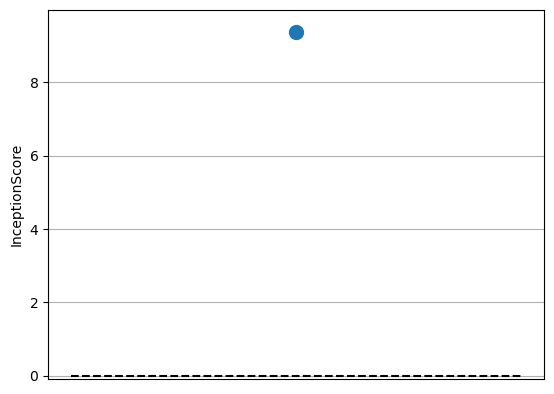

In [25]:
print(inception.compute())
fig_, ax_ = inception.plot()
fig_